In [36]:
import argparse
# import cortex

import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

# from util.data_util import load_model_performance

In [3]:
%matplotlib inline

In [4]:
subj=1
output_dir = "/user_data/yuanw3/project_outputs/NSD/output"

In [5]:
def zscore(mat, axis=None):
    if axis is None:
        return (mat - np.mean(mat)) / np.std(mat)
    else:
        return (mat - np.mean(mat, axis=axis, keepdims=True)) / np.std(
            mat, axis=axis, keepdims=True
        )

def project_vals_to_3d(vals, mask):
    all_vals = np.zeros(mask.shape)
    all_vals[mask] = vals
    all_vals = np.swapaxes(all_vals, 0, 2)
    return all_vals

def make_pc_volume(subj, vals, mask_with_significance=False):
    mask = cortex.utils.get_cortical_mask(
        "subj%02d" % subj, "func1pt8_to_anat0pt8_autoFSbbr"
    )

    try:
        cortical_mask = np.load(
            "../output/voxels_masks/subj%d/cortical_mask_subj%02d.npy" % (subj, subj)
        )
    except FileNotFoundError:
        cortical_mask = np.load(
            "../output/voxels_masks/subj%d/old/cortical_mask_subj%02d.npy" % (subj, subj)
        )

    # projecting value back to 3D space
    all_vals = project_vals_to_3d(vals, cortical_mask)

    vol_data = cortex.Volume(
        all_vals,
        "subj%02d" % subj,
        "func1pt8_to_anat0pt8_autoFSbbr",
        mask=mask,
        cmap="RdPu",
        vmin=-3,
        vmax=3,
    )
    return vol_data


def make_3pc_volume(subj, PCs, mask_with_significance=False):
    mask = cortex.utils.get_cortical_mask(
        "subj%02d" % subj, "func1pt8_to_anat0pt8_autoFSbbr"
    )

    try:
        cortical_mask = np.load(
            "../output/voxels_masks/subj%d/cortical_mask_subj%02d.npy" % (subj, subj)
        )
    except FileNotFoundError:
        cortical_mask = np.load(
            "../output/voxels_masks/subj%d/old/cortical_mask_subj%02d.npy" % (subj, subj)
        )

    pc_3d = []
    for i in range(3):
        tmp = PCs[i, :] / np.max(PCs[i, :]) * 255
        # projecting value back to 3D space
        pc_3d.append(project_vals_to_3d(tmp, cortical_mask))

    red = cortex.Volume(
        pc_3d[0].astype(np.uint8),
        "subj%02d" % subj,
        "func1pt8_to_anat0pt8_autoFSbbr",
        mask=mask,
    )
    green = cortex.Volume(
        pc_3d[1].astype(np.uint8),
        "subj%02d" % subj,
        "func1pt8_to_anat0pt8_autoFSbbr",
        mask=mask,
    )
    blue = cortex.Volume(
        pc_3d[2].astype(np.uint8),
        "subj%02d" % subj,
        "func1pt8_to_anat0pt8_autoFSbbr",
        mask=mask,
    )

    vol_data = cortex.VolumeRGB(
        red,
        green,
        blue,
        "subj%02d" % subj,
        channel1color=(194, 30, 86),
        channel2color=(50, 205, 50),
        channel3color=(30, 144, 255),
    )

    return vol_data

## Weight Analysis

In [6]:
w_i = np.load("%s/encoding_results/subj%d/weights_clip_whole_brain.npy" % (output_dir, subj))
w_t = np.load("%s/encoding_results/subj%d/weights_clip_text_whole_brain.npy" % (output_dir, subj))

In [7]:
w_i.shape

(512, 107104)

In [ ]:
pca_i = PCA(n_components=5)
pca_i.fit(w_i)
np.save("%s/pca/subj%d/clip_pca_components.npy" % (output_dir, subj), pca_i.components_)

pca_t = PCA(n_components=5)
pca_t.fit(w_t)
np.save("%s/pca/subj%d/clip_text_pca_components.npy" % (output_dir, subj), pca_t.components_)

In [9]:
pca_i = PCA(n_components=5)
pca_i.fit(w_i.T)
# np.save("%s/pca/subj%d/clip_pca_components.npy" % (output_dir, subj), pca_i.components_)

pca_t = PCA(n_components=5)
pca_t.fit(w_t.T)
# np.save("%s/pca/subj%d/clip_text_pca_components.npy" % (output_dir, subj), pca_t.components_)

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [10]:
proj_i = pca_i.transform(w_i.T)
proj_t = pca_t.transform(w_t.T)

In [11]:
proj_i.shape

(107104, 5)

In [12]:
pca_i.explained_variance_ratio_

array([0.11190038, 0.10411093, 0.07739401, 0.06519626, 0.0455961 ])

In [13]:
pca_t.explained_variance_ratio_

array([0.11900559, 0.1044991 , 0.07255385, 0.06377176, 0.04721374])

In [14]:
pcs_i = pca_i.components_
pcs_t = pca_t.components_

In [15]:
pcs_i.shape

(5, 512)

In [16]:
volumes = {}

# Normalize the PCs
# pcs_i_zscore = zscore(pcs_i, axis=1)
# pcs_t_zscore = zscore(pcs_t, axis=1)

pcs_i_zscore = zscore(proj_i.T, axis=1)
pcs_t_zscore = zscore(proj_t.T, axis=1)

for i in range(pcs_i.shape[0]):
    key = "imagePC_" + str(i)
    volumes[key] = make_pc_volume(
        subj, pcs_i_zscore[i, :], mask_with_significance=False
    )

volumes["3PC_image"] = make_3pc_volume(
    subj, pcs_i_zscore, mask_with_significance=False
)

for i in range(pcs_t.shape[0]):
    key = "textPC_" + str(i)
    volumes[key] = make_pc_volume(
        subj, pcs_t_zscore[i, :], mask_with_significance=False
    )

volumes["3PC_text"] = make_3pc_volume(
    subj, pcs_t_zscore, mask_with_significance=False
)

cortex.webgl.show(data=volumes, autoclose=False, port=24124)


Started server on port 24124


<JS: window.viewer>

In [17]:
# how to interprete the PCS?
# cosine similarity with existing words?

In [30]:
face_roi_mask = np.load("%s/voxels_masks/subj%01d/roi_1d_mask_subj%02d_%s.npy" % (output_dir, subj, subj, "floc-faces"))

In [31]:
FFA1 = face_roi_mask==2
FFA2 = face_roi_mask==3

In [32]:
FFA = (FFA1 + FFA2) > 0

In [33]:
# Total Face voxel
np.sum(FFA)

794

In [34]:
face_w_i = w_i[:, FFA]
face_w_t = w_t[:, FFA]

In [35]:
face_w_i.shape

(512, 794)

In [105]:
face_pca_i = PCA(n_components=5)
face_pca_i.fit(face_w_i)

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [106]:
face_pca_t = PCA(n_components=5)
face_pca_t.fit(face_w_t)

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

### Use CLIP embeddings of common english words to probe PCs

In [8]:
import clip
import torch

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [11]:
model.extra_repr

<bound method Module.extra_repr of CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_

In [23]:
def extract_text_activations(word_lists):
    activations = []
    for word in word_lists:
        text = clip.tokenize([word]).to(device)
        with torch.no_grad():
            activations.append(model.encode_text(text).data.numpy())
    return np.array(activations)

In [20]:
from nltk.corpus import wordnet
with open("../output/1000eng.txt") as f:
    out = f.readlines()

In [21]:
common_words = ["photo of " + w[:-1] for w in out]

In [27]:
activations = extract_text_activations(common_words)

In [28]:
activations.shape

(1000, 1, 512)

In [36]:
scores = np.mean(activations.squeeze() @ face_w_t, axis=1)
print(np.array(common_words)[np.argsort(scores)[:30]])
print(np.array(common_words)[np.argsort(scores)[::-1][:30]])

['photo of land' 'photo of section' 'photo of property' 'photo of station'
 'photo of ground' 'photo of area' 'photo of island' 'photo of yard'
 'photo of view' 'photo of plain' 'photo of place' 'photo of build'
 'photo of stood' 'photo of open' 'photo of field' 'photo of lake'
 'photo of base' 'photo of current' 'photo of house' 'photo of range'
 'photo of garden' 'photo of end' 'photo of south' 'photo of road'
 'photo of office' 'photo of stand' 'photo of east' 'photo of rail'
 'photo of plan' 'photo of camp']
['photo of person' 'photo of year' 'photo of smile' 'photo of laugh'
 'photo of slave' 'photo of caught' 'photo of women' 'photo of child'
 'photo of girl' 'photo of subject' 'photo of young' 'photo of pose'
 'photo of face' 'photo of people' 'photo of friend' 'photo of master'
 'photo of fear' 'photo of trouble' 'photo of children' 'photo of boy'
 'photo of dad' 'photo of self' 'photo of kind' 'photo of strange'
 'photo of son' 'photo of happy' 'photo of anger' 'photo of pictu

In [130]:
scores = np.mean(activations.squeeze() @ face_w_i, axis=1)
print(np.array(common_words)[np.argsort(scores)[:30]])
print(np.array(common_words)[np.argsort(scores)[::-1][:30]])

['lone' 'view' 'plain' 'section' 'map' 'pretty' 'island' 'corner' 'land'
 'ground' 'cloud' 'station' 'house' 'path' 'south' 'office' 'quiet' 'wide'
 'yard' 'valley' 'place' 'coast' 'gray' 'rail' 'west' 'sky' 'region'
 'home' 'tree' 'distant']
['pose' 'crease' 'smile' 'caught' 'us' 'slave' 'face' 'laugh' 'family'
 'me' 'dad' 'him' 'child' 'doctor' 'science' 'friend' 'person' 'human'
 'children' 'skin' 'self' 'them' 'observe' 'teeth' 'trouble' 'chick'
 'young' 'fly' 'girl' 'head']


## Visualize performance on test data

In [37]:
model = "cat_person_subset"
yhat, ytest = np.load(output_dir + "/encoding_results/subj1/pred_%s_whole_brain.p" % model)

In [42]:
out = np.load(output_dir + "/encoding_results/subj1/corr_%s_whole_brain.p" % model)

In [19]:
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
corrs = [pearsonr(ytest[:, i], yhat[:, i]) for i in range(ytest.shape[1])]

In [20]:
corr_values = [v[0] for v in corrs]

(array([ 1196., 33571., 45640., 14643.,  6682.,  3028.,  1393.,   569.,
          287.,    95.]),
 array([-0.14107483, -0.06044275,  0.02018933,  0.10082141,  0.18145349,
         0.26208557,  0.34271765,  0.42334973,  0.50398181,  0.58461389,
         0.66524597]),
 <a list of 10 Patch objects>)

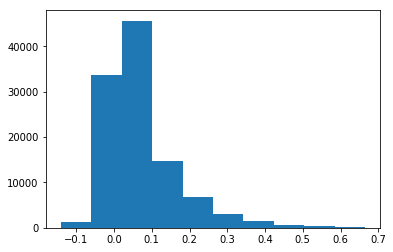

In [21]:
plt.hist(corr_values)

In [30]:
print(np.argmax(corr_values))
print(np.max(corr_values))

105433
0.665245967145746


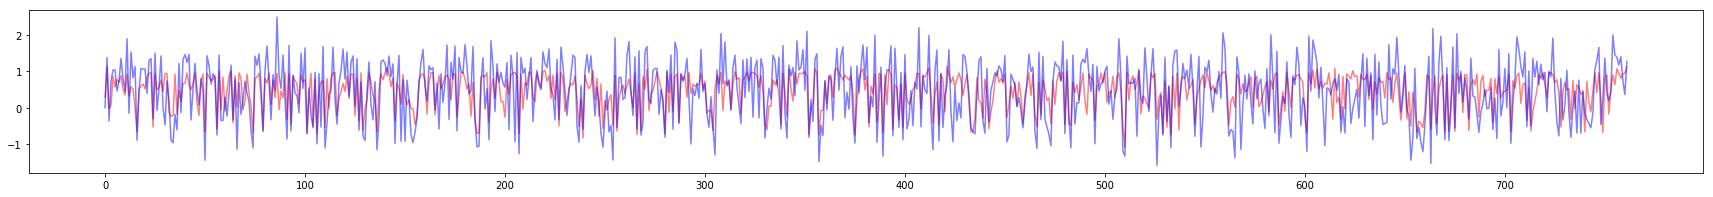

In [29]:
plt.figure(figsize=(30,3))
plt.plot(yhat[:,105433], "r", alpha=0.5)
plt.plot(ytest[:,105433], "b", alpha=0.5)


In [33]:
pvalues = load_model_performance(model, task=None, output_root=output_dir, subj=1, measure="pvalue")
sig_mask = pvalues <= 0.05

NameError: name 'load_model_performance' is not defined

In [ ]:
corrs = [pearsonr(ytest[i, :], yhat[i, :]) for i in range(ytest.shape[0])]

In [44]:
ytest.shape

(762, 107104)